# Regression Problem

## General Report
After trying many models and feature manipulations, XGBoost with some simple data processing gave us the best results. Many of the issues we faced can be attributed to the given data set - especially in terms of the instance to feature ratio, which made getting accurate results difficult as models have few samples to learn from, as well as many features that introduce noise.

Tree based models, and especially boosted trees, were favoured as they are relatively robust when tackling small, noisy datasets. 

Linear models did not perform as badly as we had assumed (seeing only some linear relationships in the data), especially when modified with kernels and polynomial features. In the final analysis, however, they exhibited too much bias to outperform XGBoost, which exhibited variance but gave better results on the testing set. Even with transformations and removal, skewed distributions and high presence of outliers strongly affected distance based algorithms. Again, likely because the data set was small and any loss of information was detrimental.

Probabilistic models such as Naive Bayes, however, gave us bad results throughout - likely because of many dependant features such as 'acous' and 'nrgy'. Removing features, however, hurt the performance of most models, likely because the lack of instances meant relying on preserving as much of the variance in the data as possible.

In the end, ensemble methods delivered the best results because they combine the power of multiple algorithms which manage to fit well to complex data that exhibits a lot of variance. Boosted Trees in particular, with their repeated iterations of random forests that fit to each other's residuals made for the most robust model out of what was attempted. The fact that the random forests are made with random subsets of features also contributed to their ease of use, as iterations with promising randomly selected feature combinations guided the model's construction.

Here are some things that were attempted but did not give good enough results:

Data

- bucketing continuous features like 'year' into 'decades'
- making ordinal feature out of song rankings in order of popularity 
- removing highly correlated features
- different kinds of encoding (especially one-hot)

Model configuration
- many ensemble methods such as stacking more boosted trees, as well as models from other families
- taking differently weighted mean predictions of different models
- manipulating regularisation hyperparameters such as 'max_depth'
- Using hyperparameter tuning techniques such as GridSearch (took too long)


In [220]:
current_best_score = 6.71

In [5]:
#importing libraries 

#basic libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

#plotting libraries
import matplotlib
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns

## Exploring the Data

In [6]:
#loading data
r_data = pd.read_csv('CS98XRegressionTrain.csv')
r_data_test = pd.read_csv('CS98XRegressionTest.csv')

In [7]:
#looking at rows/columns 
column_names = [x for x in r_data.columns]

r_columns = len(r_data.columns)
r_rows = len(r_data)

print('We have {} columns and {} rows in our regression training dataframe.'.format(r_columns, r_rows))

#Looking at general information
print('\nSome general information about the dataframe: ')
training_dataframe_info = r_data.info()

We have 15 columns and 453 rows in our regression training dataframe.

Some general information about the dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   top genre  438 non-null    object
 4   year       453 non-null    int64 
 5   bpm        453 non-null    int64 
 6   nrgy       453 non-null    int64 
 7   dnce       453 non-null    int64 
 8   dB         453 non-null    int64 
 9   live       453 non-null    int64 
 10  val        453 non-null    int64 
 11  dur        453 non-null    int64 
 12  acous      453 non-null    int64 
 13  spch       453 non-null    int64 
 14  pop        453 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 53.2+ KB


The Non-Null count for 'top genre' is lower than the other columns, so we will have to deal with missing values there.

Our first observation is that there is a high ratio of features to instances - we also don't have many instances to learn from in the first place. We may need to think about models that work well with low amounts of higher-dimensional data, and about being selective with features we want to use.


In [8]:
#Looking at the train/test split
print('We have {} rows in the training sets.\n'.format(len(r_data)))
print('We have {} rows in the testing sets.\n'.format(len(r_data_test)))
data_total = r_rows + len(r_data_test)
train_split = (r_rows/data_total)*100
test_split = (100 - train_split)

print('The train/test split is about {:.2f}%/{:.2f}%'.format(train_split, test_split))

We have 453 rows in the training sets.

We have 114 rows in the testing sets.

The train/test split is about 79.89%/20.11%


## Missing Data/Values

In [9]:
#looking for how many values are missing, as well as which columns have the NaNs
n_missing = r_data.isnull().sum().sum()
genre_missing = r_data['top genre'].isnull().sum().sum()

print('Are there only missing "top genre" values?',genre_missing == n_missing)

print('We have {} values missing from the training data.'.format(n_missing))

Are there only missing "top genre" values? True
We have 15 values missing from the training data.


In [10]:
#let's look at those rows closely
missing_genres = r_data.loc[r_data['top genre'].isnull() == True]
missing_genres

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
8,9,Someone Elses Roses,Joan Regan,NaN,2019,100,14,29,-10,15,32,143,89,3,34
26,27,Drinks On The House,Green Martini Keys,NaN,2016,97,16,57,-16,11,15,181,100,5,28
72,73,Pachuko Hop,Ike Carpenter Orchestra,NaN,2006,83,53,48,-9,34,80,135,59,3,28
90,91,Little Things Means A Lot,Jayne Mansfield,NaN,2008,109,29,70,-15,16,63,172,36,4,29
98,99,The Lady Is A Tramp,Mel Torme & the Mel-Tones,NaN,2016,138,60,41,-8,41,54,170,81,6,40
220,221,If I Give My Heart To You,The Teddy Bears,NaN,2011,113,29,49,-10,12,29,118,86,3,40
252,253,Happy Days And Lonely Nights,Suzi Miller And Johnson Brothers,NaN,2012,142,38,65,-8,13,69,146,43,3,27
265,266,Stairway Of Love,Terry Dene,NaN,2015,93,62,62,-7,25,86,120,55,4,27
266,267,You,Ten Sharp,NaN,1991,174,90,41,-8,19,67,273,43,3,61


NaN value rows were dropped for higher final model accuracy.


In [11]:
#dropping missing values
r_data.drop(r_data[r_data['top genre'].isnull() == True].index, inplace = True)

print('The number of rows is now: ', len(r_data))

The number of rows is now:  438


## Exploratory Data Analysis

We decided to focus on analysis that shows major overviews of features first, so that we would know what to focus on. 


<ipython-input-12-7f2ca3363d6e>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  r_data.hist(ax = ax, bins = 10)


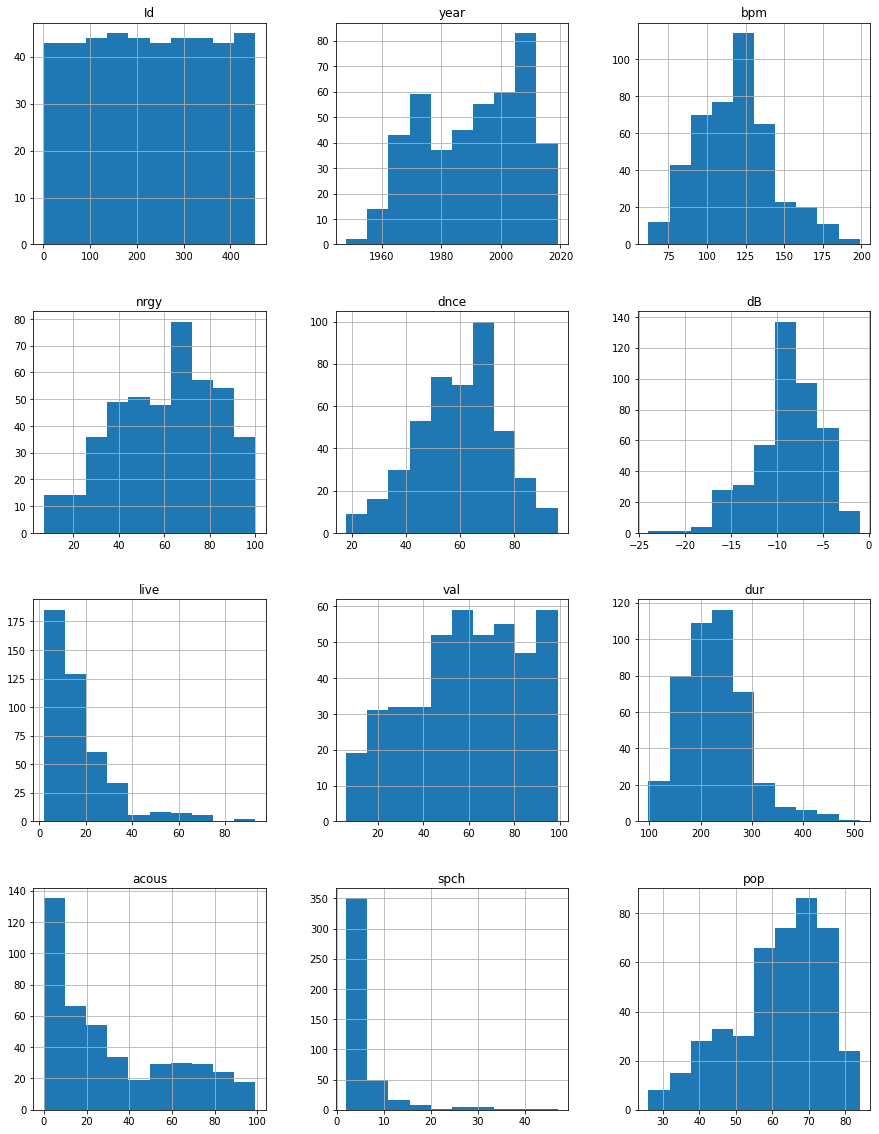

In [12]:
#plotting histograms of the continuous features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
r_data.hist(ax = ax, bins = 10)
fig.show()

- 'bpm', 'nrgy', 'dnce', 'dB', 'dur' and 'pop' seem to have fairly normal distributions, but some are more skewed than others. The left skew of 'pop' is particularly important, as this is our target variable. 

- Many of the other features have a lot of skewness, like 'live' and 'spch'.

- Much of the data is in different scales as well(especially dB) 

All this means that we should think about transformation methods if using regression based models sensitive to uneven distributions (linear/logistic reg) and scaling methods for models that are sensitive to scale (like SVMs). This is part of why we used Decision-tree based algorithms in the end, which are much less sensitive to these types of variation in the data.

## Continuous feature correlation heatmap

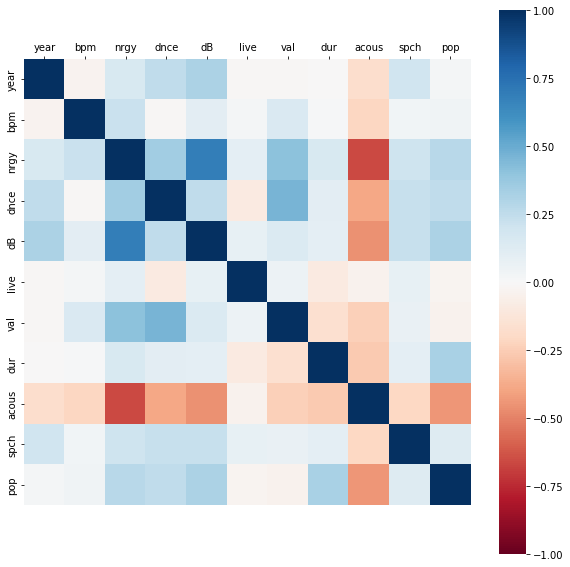

In [13]:
#dropping categorical/textual data
continuous_features = r_data.drop(['Id', 'title', 'artist', 'top genre'],inplace = False,axis = 'columns',)
continuous_features.head()

#plotting heatmap of correlation matrix 
fig, ax_hm = plt.subplots(figsize=(10, 10))
ax_heatmap = sns.heatmap(continuous_features.corr(), cmap = 'RdBu', vmin = -1, vmax = 1, square = True, ax = ax_hm)
ax_heatmap.set(xlabel = '', ylabel = '')
ax_heatmap.xaxis.tick_top()

Positive Correlations
- valence and danceability
- valence and energy
- dB and energy

Negative Correlations
- acousticness and energy
- acousticness and dB

### **Popularity Score**
- small positive with energy, danceability, dB, duration, speechiness
- medium negative with acousticness
- little to no correlation at all with valence, live, bpm or year

It seems like popular songs are:
- less acoustic 
- longer duration
- louder

There is a clear inverse linear relationship between "nrgy" and "acous":



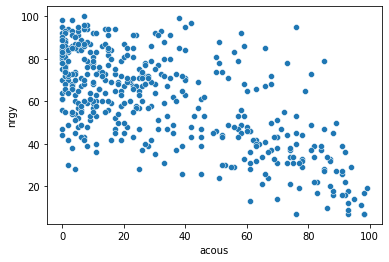

In [14]:
#Plotting 'nrgy' with 'acous'
sns.scatterplot(data=r_data,x=r_data['acous'], y=r_data['nrgy'])

print('There is a clear inverse linear relationship between "nrgy" and "acous":\n')

### Looking at popularity summary stats


In [15]:
#looking at summary statistics/measures of central tendency/spread
r_data['pop'].describe()

count    438.000000
mean      61.557078
std       12.759353
min       26.000000
25%       54.000000
50%       64.000000
75%       72.000000
max       84.000000
Name: pop, dtype: float64

Values are likely on a 0 - 100 scale

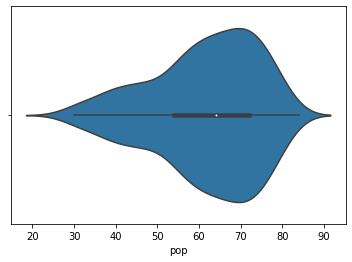

In [16]:
sns.violinplot(x = r_data ['pop'])

Popularity scores being bounded to 100 and mostly distributed near 70 means either the data is a biased sample or there are biases in how popularity is computed. 


### Let's look at the features which correlate with popularity score directly


In [17]:
def feature_plotting(feature_name, target):

  colour = np.random.rand(3,)

  print('Summary stats for {}:\n'.format(feature_name) )
  print(r_data[feature_name].describe())
  plt.show()
  print('\nBoxplot will show us spread and highlight outliers:\n')
  sns.boxplot(x = r_data [feature_name], color = colour)
  plt.show()
  print('\nScatterplot will show us relationship between {} and {}:\n'.format(feature_name, target))
  sns.scatterplot(data=r_data,x = r_data[feature_name], y = r_data[target], color = colour)
  plt.show()

Summary stats for spch:

count    438.000000
mean       5.671233
std        5.571392
min        2.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       47.000000
Name: spch, dtype: float64

Boxplot will show us spread and highlight outliers:



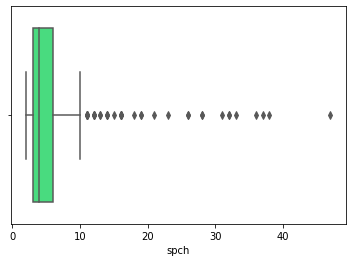


Scatterplot will show us relationship between spch and pop:



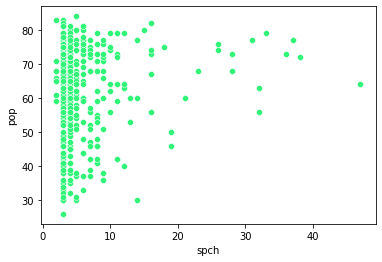

In [18]:
feature_plotting('spch', 'pop')

Majorly skewed feature with many outliers - an example of dataset noise. Was considered to be dropped but hurt accuracy.

Summary stats for val:

count    438.000000
mean      59.625571
std       24.480160
min        6.000000
25%       42.250000
50%       61.000000
75%       80.000000
max       99.000000
Name: val, dtype: float64

Boxplot will show us spread and highlight outliers:



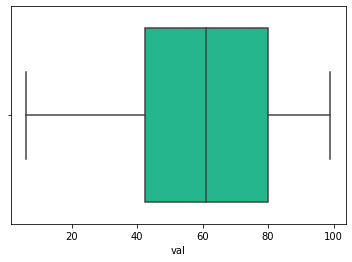


Scatterplot will show us relationship between val and pop:



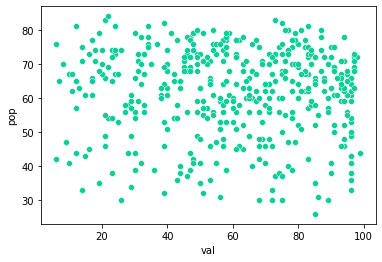

In [19]:
feature_plotting('val', 'pop')

Scatterplot shows some of the high level of variance in the dataset. Some clustering in the higher regions of each feature though, so still useful. 

## Data Pre-processing

Making some additional changes to the data for the training stage. In particular, we label encoded the categorical features. One-hot encoding was considered first, but it doesn't work as well for tree-based models because adding a sparse feature vector for each category means that required tree depth is increased by a large factor which introduces error. 



## Preparing Data

Here we apply the final transformations on the data that gave the best results.


**log transform**

- 'pop' is left skewed, so normalising the distribution means that the DT's leaf splitting decision function is less heavily weighted towards higher values, meaning more even splits.

**standardization**

- Though DTs are usually not sensitive to monotonic transformations, putting data on the same scale made the decision function slightly less sensitive to outliers. Small difference, but gave better results.


**power transform**

- Another normalisation that helped stabilise the distributions in the dataset. Helps with the optimisation step of XGBoost and majorly sped up training.


**label encoding**

- Though one-hot encoding is usually preferred, it harms the performance of DTs by adding sparse features that create unnecessary splits in the data. High category cardinality also an issue as many features are added.


In [134]:
#importing libraries we will use

#data prep
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
#eval
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [167]:
def drop_columns(X_train, X_test, column_list, make_copy = False):
  #function for dropping specified rows
  if make_copy == True:
    X_train = copy.deepcopy(X_train)
    X_test = copy.deepcopy(X_test)

  X_train_dropped = X_train.drop(column_list, axis = 1)
  X_test_dropped = X_test.drop(column_list, axis = 1)

  return X_train_dropped, X_test_dropped


def transform_features(df, columns, transformer_name, transf_dict):
  #function for scaling or normalising specified features

  if transf_dict is None:

    if transformer_name == 'Standard':
      transf = preprocessing.StandardScaler()
  
    elif transformer_name == 'MinMax':
     transf = preprocessing.MinMaxScaler()

    elif transformer_name == 'Robust':
      transf = preprocessing.RobustScaler()
  
    elif transformer_name == 'PowerTransformer':
      transf = preprocessing.PowerTransformer()
  
    #make a dictionary of the fitted transformer so that we can use training scales for testing data

    transf_dict = {}
    
    for col in columns:
      col_transf = copy.deepcopy(transf)
      col_transf = col_transf.fit(df[[col]])
      df[col] = col_transf.transform(df[[col]])
      transf_dict[col] = col_transf
	
  else:
    for col in columns:
      transf = transf_dict.get(col)
      df[col] = transf.transform(df[[col]])
    
    return df

  return df, transf_dict #returning dictionary and df with scaled features

def label_encoding(X_train, X_test, column):

  train_len = len(X_train)
  label_encoder = preprocessing.LabelEncoder()

  full_data = pd.concat([X_train[column], X_test[column]], axis = 0,ignore_index=True)
  
  full_data_enc = label_encoder.fit_transform(full_data.values)
  
  X_train_enc = full_data_enc[:train_len]
  X_test_enc = full_data_enc[train_len:]

  return X_train_enc, X_test_enc, label_encoder


def train_test(train_data, test_data, target,  drop_columns, make_copy = False):
  #copies data drops unwanted rows
  if make_copy == True:
    train_data = copy.deepcopy(train_data)
    test_data = copy.deepcopy(test_data)
    
    y_train = train_data[target]
    X_train = train_data.drop([target], axis = 1)

    X_test = test_data.drop(drop_columns, axis = 1)
    X_train = X_train.drop(drop_columns, axis = 1)

    return X_train, y_train, X_test

#for evaluation
def display_scores(scores, negative_result = False):

  if negative_result == True:
    scores = np.array([abs(x) for x in scores])

  print("Scores:")

  for i,score in enumerate(scores):
    print('Fold {} - {:.3f}'.format(i, score))

  print("\nMean: {:.3f}".format(scores.mean()))
  print("Standard deviation: {:.3f}".format(scores.std()))
  print('\n')

def learning_curve(model, X, y, xgb = False):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
  train_errors, val_errors = [], []

  if xgb == True:
    y_train = y_train.values.ravel()


  for m in range(1, X_train.shape[0]):
      model.fit(X_train[:m], y_train[:m])
      y_train_predict = model.predict(X_train[:m])
      y_val_predict = model.predict(X_val)

      train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
      val_errors.append(mean_squared_error(y_val, y_val_predict))

  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")


def plot_learning_curve(model, X, y, xgb = False):

  plt.figure(figsize=(6,4), dpi=120)
  learning_curve(model, X, y, xgb = xgb)
  plt.ylim(top=20);
  plt.legend();
  plt.xlabel('Training set size');
  plt.ylabel('RMSE');


def log_transform(x):
  return np.log(x)

def inverse_transform(x):
  return np.exp(x)

In [168]:
#data setup 

dropping_columns = ['Id', 'title']
target = 'pop'

X_train, y_train, X_test = train_test(r_data, r_data_test, target,  dropping_columns, make_copy = True)


In [169]:
#data prep

#label encoding 

#artist
train_artist_enc, test_artist_enc, artist_encoder = label_encoding(X_train, X_test, 'artist')

X_train['artist'] = train_artist_enc
X_test['artist'] = test_artist_enc

#top genre
train_genre_enc, test_genre_enc, genre_encoder = label_encoding(X_train, X_test, 'top genre')

X_train['top genre'] = train_genre_enc
X_test['top genre'] = test_genre_enc

#scaling and transforming conitnuous data
cont_data = ['year', 'bpm',	'nrgy',	'dnce',	'dB',	'live',	'val', 'dur',	'acous', 'spch']


#Power transforming continuous features
X_train, powertf_dict = transform_features(X_train, cont_data, 'PowerTransformer', transf_dict = None)
X_test = transform_features(X_test, cont_data, 'PowerTransformer', transf_dict = powertf_dict)

#Standardizing continuous features
X_train, standard_scalers = transform_features(X_train, cont_data, 'Standard', transf_dict = None)
X_test = transform_features(X_test, cont_data, 'Standard', transf_dict = standard_scalers)

### Dummy Model

In [170]:
#model fitting and prediction
dummy_reg = DummyRegressor(strategy = 'median')
#log transform target with pipeline
dummy_reg = TransformedTargetRegressor(regressor = dummy_reg, func = log_transform, inverse_func = inverse_transform)

dummy_reg.fit(X_train, y_train)

y_dummy_eval = dummy_reg.predict(X_train)

Cross Validation
Scores:
Fold 0 - 14.052
Fold 1 - 14.065
Fold 2 - 11.870
Fold 3 - 11.270
Fold 4 - 12.967
Fold 5 - 13.053
Fold 6 - 13.254
Fold 7 - 14.205
Fold 8 - 12.263
Fold 9 - 12.214

Mean: 12.921
Standard deviation: 0.956


The RMSE of Dummy Regressor is: 12.977

Learning Curve for Dummy model:



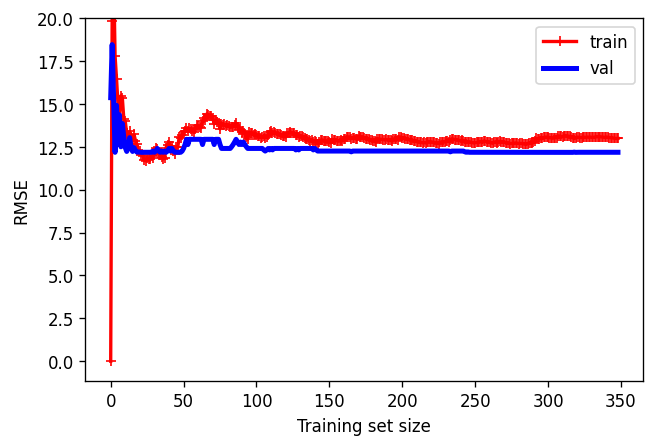

In [171]:
#model evaluation
dummy_rmse = mean_squared_error(y_dummy_eval, y_train, squared = False)


dummy_cv_scores = cross_val_score(dummy_reg, X_train, y_train,
scoring="neg_root_mean_squared_error", cv=10)


print('Cross Validation')
display_scores(dummy_cv_scores, negative_result = True)


print('The RMSE of Dummy Regressor is: {:.3f}\n'.format(dummy_rmse))

#plotting the learning curve

print('Learning Curve for Dummy model:\n')

plot_learning_curve(dummy_reg, X_train, y_train)

Random model exhibits high bias as expected

 ### Baseline Model

In [172]:
#model fitting and prediction
lin_reg = LinearRegression()

lin_reg = TransformedTargetRegressor(regressor = lin_reg, func = log_transform, inverse_func = inverse_transform)

lin_reg.fit(X_train, y_train)

y_lin_eval = lin_reg.predict(X_train)

Cross Validation
Scores:
Fold 0 - 12.636
Fold 1 - 9.927
Fold 2 - 11.011
Fold 3 - 8.136
Fold 4 - 11.863
Fold 5 - 13.953
Fold 6 - 10.646
Fold 7 - 11.084
Fold 8 - 12.794
Fold 9 - 9.216

Mean: 11.127
Standard deviation: 1.669


The RMSE of Linear Regression is: 10.781

Learning Curve for Linear Regression model:



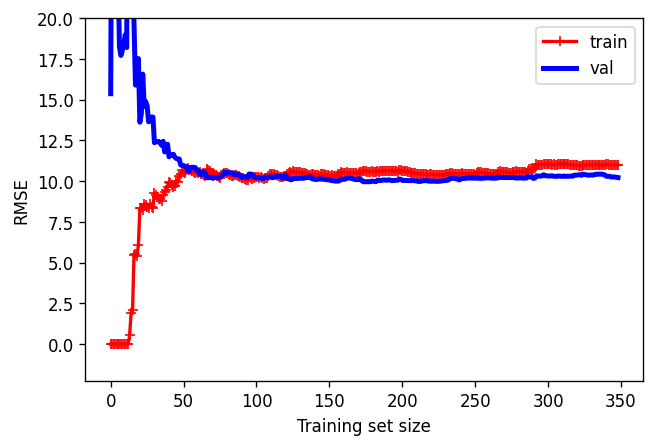

In [204]:
#model evaluation
lin_rmse = mean_squared_error(y_lin_eval, y_train, squared = False)


lin_cv_scores = cross_val_score(lin_reg, X_train, y_train,
scoring="neg_root_mean_squared_error", cv=10)


print('Cross Validation')
display_scores(lin_cv_scores, negative_result = True)


print('The RMSE of Linear Regression is: {:.3f}\n'.format(lin_rmse))

#plotting the learning curve

print('Learning Curve for Linear Regression model:\n')

train_errors = plot_learning_curve(lin_reg, X_train, y_train)

LR is underfitting with high bias

## Final Model: XGBoost Regression


In [183]:
xgb_reg = XGBRegressor(max_depth=4, n_estimators=120, reg_lambda=2, reg_alpha=1, subsample=0.925, colsample_bytree=0.95, verbosity = 0)

xgb_reg = TransformedTargetRegressor(regressor = xgb_reg, func = log_transform, inverse_func = inverse_transform)

xgb_reg.fit(X_train, y_train)

#model prediction
y_pred = xgb_reg.predict(X_test)

### Model Evaluation

Cross Validation
Scores:
Fold 0 - 11.958
Fold 1 - 8.958
Fold 2 - 10.063
Fold 3 - 9.747
Fold 4 - 13.589
Fold 5 - 13.739
Fold 6 - 9.615
Fold 7 - 10.421
Fold 8 - 12.325
Fold 9 - 9.191

Mean: 10.960
Standard deviation: 1.703


Learning Curve for XGBoost model:

The training RMSE of XGBoost Regression is: 6.733
The testing RMSE of XGBoost Regression is  6.71


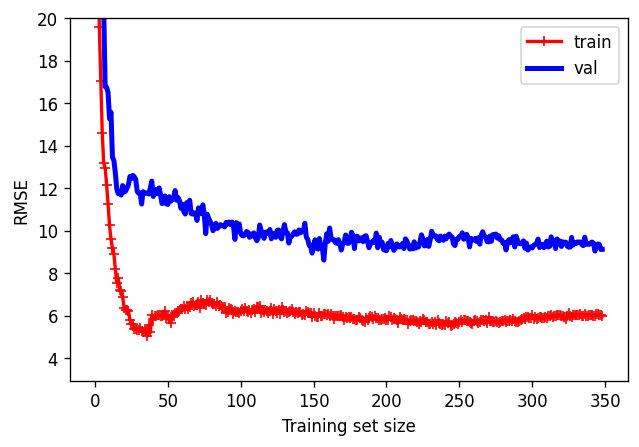

In [203]:
y_eval = xgb_reg.predict(X_train)

xgb_rmse = mean_squared_error(y_train,y_eval, squared = False)


xgb_cv_scores = cross_val_score(xgb_reg, X_train, y_train,
scoring="neg_root_mean_squared_error", cv=10)


print('Cross Validation')
display_scores(xgb_cv_scores, negative_result = True)

#plotting the learning curve

print('Learning Curve for XGBoost model:\n')

plot_learning_curve(xgb_reg, X_train, y_train)



print('The training RMSE of XGBoost Regression is: {:.3f}'.format(xgb_rmse))

print('The testing RMSE of XGBoost Regression is ', current_best_score)

Clear signs of overfitting. Made for best results because of low overall bias but will not generalise well. The trade off is balanced in a way that produced best results by a small margin.

Though training and testing scores (based on kaggle result) are similar, testing RMSE is assumed to increase with the second half of testing.

### Comparisons

[Text(0, 0.5, ' Training RMSE'), Text(0.5, 0, 'Model')]

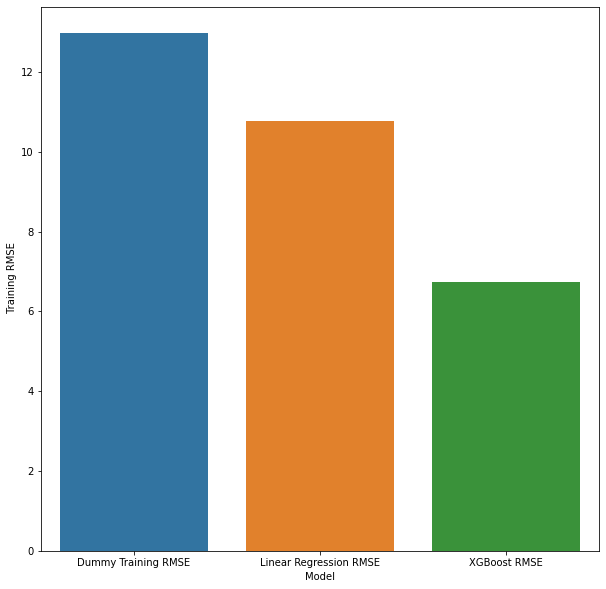

In [219]:
training_RMSE = [dummy_rmse, lin_rmse, xgb_rmse]
training_RMSE = pd.DataFrame({'Dummy Training RMSE':dummy_rmse, 'Linear Regression RMSE':lin_rmse, 'XGBoost RMSE':xgb_rmse}, index = training_RMSE)

fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(data = training_RMSE)
ax.set(xlabel='Model', ylabel=' Training RMSE')

XGBoost performs best on training due to overfit.

Text(0.5, 0, 'Average CV RMSE')

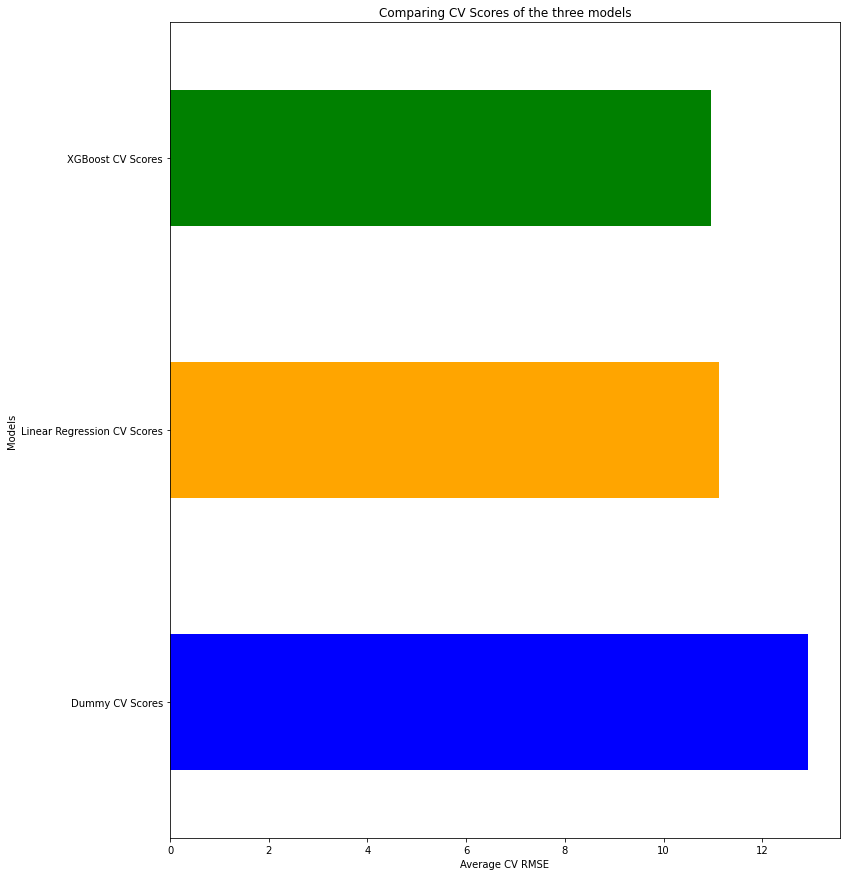

In [208]:
def invert_score(cv_scores):
  scores_list = [abs(x) for x in cv_scores]

  return np.array(scores_list)

cv_comparison_data = pd.DataFrame({'Dummy CV Scores':invert_score(dummy_cv_scores), 'Linear Regression CV Scores':invert_score(lin_cv_scores), 'XGBoost CV Scores':invert_score(xgb_cv_scores)}, index = range(1,11))


cv_comparison_data.mean().plot.barh(title = 'Comparing CV Scores of the three models', figsize = (12,15), xlabel = 'Models', ylabel = 'RMSE', color = ['blue', 'orange', 'green'])
plt.xlabel('Average CV RMSE')

Small difference in mean CV Scores, which are used as better approximation of generalisation. Shows room for improvement for XGBoost.

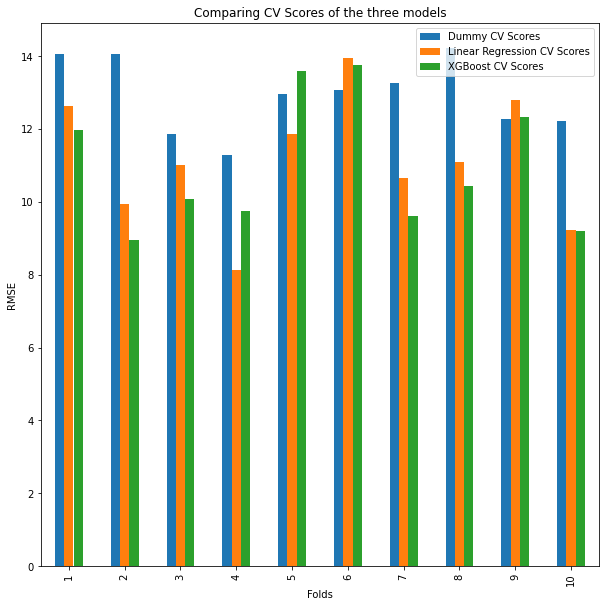

In [209]:
cv_comparison_data.plot(kind = 'bar', title = 'Comparing CV Scores of the three models', figsize = (10,10), xlabel = 'Folds', ylabel = 'RMSE')



Validation Scores for baseline and XGBoost seem close to each other because XGBoost is severely overfitting to the training data, whereas the baseline has fit quite well, but trades variance for bias. LR actually performs better in folds 4 and 5, showing the problem.

## Conclusion

There is definitely room for improvement with the XGBoost model. Though it gave the best result, it shows clear signs of overfitting. Regularisation parameters are needed but it is a delicate balance as we trade variance for bias and risk hurting overall accuracy.

Though results could be improved, there is small room for error with a dataset this small and noisy. The kaggle competition standings reflect this, as scores near the top are close to us.



## Reflections

Much of our time was spent in the process of realising that cutting instances because of outliers or features because of noise and multicollinearity was reducing information that models needed to have any predictive power. It would have been better to spend that time trying to engineer new features so that models would have more to learn from in the small dataset.

We also realised that more time should have been spent on regularisation methods and hyperparamers that could help alleviate XGBoost's major overfitting problem.

We believe that with enough time, we could have made decent models from other families and formed a balanced ensemble model that could leverage the strengths of different algorithms. This would have meant dealing with overfitting in some model types and underfitting in others, which amounts to a very complex task. Our main idea was to make a large ensemble and average its predictions, and we still believe that this would be the best approach to this problem.


With more time, would try more feature engineering/extraction. We tried many things and ended up with the same or worse results, but more EDA could have inspired useful attempts.

In the end, the data given made getting a high accuracy unlikely anyway - in other contexts, data acquisition would have been prioritised.


### Uploading predictions

In [210]:
predictions = pd.DataFrame(data = y_pred, columns = ['pop'])

id = pd.DataFrame(data = r_data_test['Id'], columns = ['Id'])
predictions = pd.merge(id, predictions, right_index = True, left_index = True)

predictions

# predictions.to_csv('spotify_regression.csv', index=False)

,Id,pop
0,454,69.881065
1,455,70.046501
2,456,62.196884
3,457,63.993439
4,458,47.012543
...,...,...
109,563,66.146629
110,564,65.600372
111,565,63.910522
112,566,64.216522
